# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\noah\labs\hw2-nh422`
   Installed Preferences ─────────────── v1.4.0
   Installed GR_jll ──────────────────── v0.72.7+0
   Installed JpegTurbo_jll ───────────── v2.1.91+0
   Installed Libmount_jll ────────────── v2.35.0+0
   Installed Xorg_xkbcomp_jll ────────── v1.4.2+4
   Installed LoggingExtras ───────────── v1.0.0
   Installed Accessors ───────────────── v0.1.37
   Installed RelocatableFolders ──────── v1.0.0
   Installed InlineStrings ───────────── v1.4.0
   Installed Unitful ─────────────────── v1.14.0
   Installed ConcurrentUtilities ─────── v2.2.0
   Installed Roots ───────────────────── v2.1.6
   Installed Contour ─────────────────── v0.6.2
   Installed Formatting ──────────────── v0.4.2
   Installed OpenSSL ─────────────────── v1.4.1
   Installed InvertedIndices ─────────── v1.3.0
   Installed PlotUtils ───────────────── v1.3.5
   Installed HTTP ────────────────────── v1.9.7
   Installed Xorg_libpthread_stubs_jll ─ v0.1.0+3
   Installed DataF

In [3]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

**[IMPORTANT (PLEASE READ)]** The write ups for this homework are much shorter than i had expected, the problems themselves are much more computational than analytical in my opinion, therefore the code and comments found within the  will explain my though process as thoroughly as possible

**[Write-up]**
to start, i took all of the given information and created variables for each of the given constants with units added as comments. after, i calculated the concentration of CRUD for the river inflow, source 1, and source 2 by multiplying the flow by the amount of CRUD discharged per 1000m3 of water. then, i had to take exponential decay into account for the 15km travelled from source 1 to source 2. lastly, a mass balance after source 2 was calculated to check compliance to ensure the system did not exceed the regulatory limit of 2.5kg/1000m3

In [5]:
# given info
Q_river_inflow = 250_000  # m3/day (river inflow)
C_river_inflow = 0.5      # kg/1000 m3 (initial CRUD concentration in river)
flow_velocity = 10        # km/day (river flow velocity)
decay_rate = 0.36         # day-1 (decay rate of CRUD)
distance_between_sources = 15  # km

# source 1 (given info)
Q_source1 = 40_000  # m3/day (discharge from source 1)
C_source1 = 9       # kg/1000 m3 (CRUD concentration from source 1)

# source 2 (given info)
Q_source2 = 60_000  # m3/day (discharge from source 2)
C_source2 = 7       # kg/1000 m3 (CRUD concentration from source 2)

# regulatory limit
regulatory_limit = 2.5  # kg/1000 m3

# mass of CRUD from source 1
mass_source1 = Q_source1 * (C_source1 / 1000)  # kg/day

# total flow after Source 1
Q_total_after_source1 = Q_river_inflow + Q_source1  # m3/day

# concentration downstream from source 1 (rounding for cleaner answer)
C_after_source1 = round((Q_river_inflow * (C_river_inflow / 1000) + mass_source1) / Q_total_after_source1 * 1000, digits=2)
println("Concentration just downstream of source 1: $C_after_source1 kg/1000 m3")

# time to travel from source 1 to source 2
time_between_sources = distance_between_sources / flow_velocity  # days

# concentration at source 2 (also rounded)
C_at_source2 = round(C_after_source1 * exp(-decay_rate * time_between_sources), digits=2)
println("Concentration at source 2 before mixing: $C_at_source2 kg/1000 m3")

# mass of CRUD from source 2
mass_source2 = Q_source2 * (C_source2 / 1000)  # kg/day

# total flow after source 2
Q_total_after_source2 = Q_total_after_source1 + Q_source2  # m3/day

# concentration downstream of source 2 (rounded)
C_after_source2 = round((Q_total_after_source1 * (C_at_source2 / 1000) + mass_source2) / Q_total_after_source2 * 1000, digits=2)
println("Concentration just downstream of source 2: $C_after_source2 kg/1000 m3")

# checking compliance with regulatory limit
if C_after_source2 <= regulatory_limit
    println("the system is in compliance with the regulatory limit.")
else
    println("the system exceeds the regulatory limit.")
end


Concentration just downstream of Source 1: 1.67 kg/1000 m³
Concentration at Source 2 before mixing: 0.97 kg/1000 m³
Concentration just downstream of Source 2: 2.0 kg/1000 m³
The system is in compliance with the regulatory limit.


> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

**[WRITE-UP]** to start, i took all of the given info and created variables for them. next, i created three functions, one for P recycling, one for P outflow, and another for the change in P concentration. next, i created a function to find equilibrium for the non-point sources using the "Roots.jl" package with another function to simulate the time steps from t=0 to 30 with increments of 1. lastly, the problem was repeated, but this time with a_t = 0.02 and a plot was created to show the P concentration over time.

Equilibrium phosphorus concentration (a_t = 0): 1.0
Equilibrium phosphorus concentration (a_t = 0.02): 1.1341008852434813


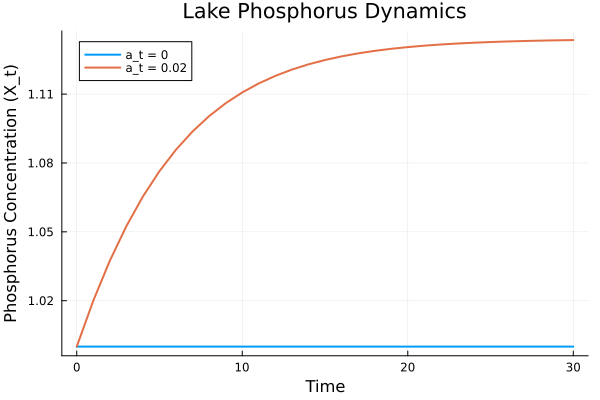

In [7]:
using Plots
using Roots

# given information
b = 0.5          # P outflow rate
q = 1.5          # recycling parameter
mu = 0.0         # mean for lognormal distribution
sigma = 0.0      # standard deviation for lognormal distribution 
time_steps = 30  # time

# function for phosphorus recycling
function X_recycling(X, q)
    return (X^q) / (1 + X^q)
end

# function for phosphorus outflow
function X_outflow(X, b)
    return b * X
end

# function for change in phosphorus concentration
function X_delta(X, a, q, b)
    return a + X_recycling(X, q) - X_outflow(X, b)
end

# non-point-source release (a_t = 0)
a_t = 0.0

# function to find equilibrium (set change in X to zero)
function equilibrium_eq(X)
    return X_delta(X, a_t, q, b)
end

# find equilibrium using 'Roots.jl'
X_eq = find_zero(equilibrium_eq, 1.0)  # initial guess for equilibrium
println("Equilibrium phosphorus concentration (a_t = 0): $X_eq")

# initial conditions
X_0 = 1.0
X_values = [X_0]

# simulate the model over time (a_t = 0)
for t in 1:time_steps
    X_next = X_values[end] + X_delta(X_values[end], a_t, q, b)
    push!(X_values, X_next)
end

# plotting (a_t = 0)
plot(0:time_steps, X_values, label="a_t = 0", xlabel="Time", ylabel="Phosphorus Concentration (X_t)", title="Lake Phosphorus Dynamics", linewidth=2)

# point-source release (a_t = 0.02)
a_t = 0.02

# finding equilibrium for the new a_t
X_eq_with_release = find_zero(X -> X_delta(X, a_t, q, b), 1.0)
println("Equilibrium phosphorus concentration (a_t = 0.02): $X_eq_with_release")

# simulate the model over time with point-source release (a_t = 0.02)
X_values_release = [X_0]

for t in 1:time_steps
    X_next = X_values_release[end] + X_delta(X_values_release[end], a_t, q, b)
    push!(X_values_release, X_next)
end

# plot the dynamics with point-source release (a_t = 0.02)
plot!(0:time_steps, X_values_release, label="a_t = 0.02", xlabel="Time", ylabel="Phosphorus Concentration (X_t)", linewidth=2)


### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

**[WRITE-UP]** to start, i took the given information and created variables. from there, i found the atmospheric phosphorus by multiplying the deposition rate by the area of the lake. lastly, the maximum point source loading was found by multiplying the loading limit of 0.02 mg/L by the outflow, then subtracting the atmospheric phosphorus.

In [9]:
# Constants
V = 600e6        # m3 (volume)
A = 30e3         # m3 (area)
Q_out = 400e6    # m3/yr (outflow)
deposition_rate = 1.6e-4  # kg/yr m2 (deposition rate)
C_lake_goal = 0.02e-3  # kg/m3 (desired phosphorus concentration, converted from mg/L to kg/m^3)

# calculating atmospheric phosphorus
atmospheric_input = deposition_rate * A  # kg/yr

# calculating maximum allowable point source loading
L_point = C_lake_goal * Q_out - atmospheric_input

println("Maximum allowable point source phosphorus loading: $L_point kg/yr")


Maximum allowable point source phosphorus loading: 7995.200000000001 kg/yr


## References

List any external references consulted, including classmates.

https://github.com/JuliaMath/Roots.jl

https://juliamath.github.io/Roots.jl/stable/